In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
hit_test = pd.read_csv("data/blast_results/blast_hit_test.tsv", sep='\t', names=["TestID", "TrainID", "Score"])

In [3]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from go_bench.metrics import threshold_stats

train_path = "/home/andrew/go_metric/data/go_bench"

train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
# test_dataset = BertSeqDataset.from_memory("data/go_bench/testing_molecular_function_annotations.tsv", 
#                                             "data/go_bench/testing_molecular_function_terms.json", 
#                                             "data/uniprot_reviewed.fasta")
# test_dataset.to_pickle(f"{train_path}/test.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

def load_annot_matrix(term_path, annot_path, seq_path):
    with open(term_path, 'r') as f:
        go_terms = json.load(f)
    annot_dict = load_GO_tsv_file(annot_path)
    dict_ids = list(annot_dict.keys())
    annot_seqs, annot_ids = load_protein_sequences(seq_path, set(dict_ids))
    annot_mat = convert_to_sparse_matrix(annot_dict, go_terms, annot_ids)
    return go_terms, annot_ids, annot_seqs, annot_mat

go_terms, train_ids, _, train_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/training_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

_, val_ids, _, val_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/validation_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

test_go_terms, test_ids, _, test_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/testing_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

with open("/home/andrew/GO_benchmarking/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}
# from qtlsearch.OBOParser import OBO
# go = OBO('/home/andrew/GO_benchmarking/data/go.obo.gz', store_as_int=True)
test_ia = np.zeros(len(test_go_terms))
for i, test_id in enumerate(test_go_terms):
    id_int = int(test_id[3:])
    if(id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]

In [4]:
from collections import Counter
hit_counts = Counter(hit_test["TestID"])
for pid in test_ids:
    if(not pid in hit_counts):
        hit_counts[pid] = 0
# import matplotlib.pyplot as plt
# plt.hist(hit_counts.values(), bins=np.arange(45))
# plt.show()

In [5]:
hit_proteins = set(hit_test["TestID"])
novel_ids= [t for t in test_ids if t not in hit_proteins]
def label_subset(labels, pids, pid_subset):
    pid_rows = {pid: idx for idx, pid in enumerate(pids)}
    return vstack([labels[pid_rows[pid]] for pid in pid_subset]) 
novel_labels = label_subset(test_labels, test_ids, novel_ids)

In [6]:
model_probs = {}
import pickle
with open("paper_result_predictions/blast.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BLAST"] = probs
with open("paper_result_predictions/conv128.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv128"] = probs
with open("paper_result_predictions/conv2048.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv2048"] = probs
with open("paper_result_predictions/conv128_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv128-Emb"] = probs
with open("paper_result_predictions/conv2048_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv2048-Emb"] = probs
with open("paper_result_predictions/bert_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BERT-Emb"] = probs
with open("paper_result_predictions/bert_finetune.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BERT-FT"] = probs
with open("paper_result_predictions/bert_finetune_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BERT-FT-Emb"] = probs
with open("paper_result_predictions/esm_finetune.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["ESM-FT"] = probs
with open("paper_result_predictions/esm_finetune_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["ESM-FT-Emb"] = probs
with open("paper_result_predictions/esm_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["ESM-Emb"] = probs

In [14]:
(model_probs['ESM-Emb'].toarray() == model_probs['ESM-FT-Emb'].toarray()).sum()


16305250

In [15]:
model_probs['ESM-Emb'].shape[0]*model_probs['ESM-Emb'].shape[1]

16305250

In [7]:
novel_stats = {}
for model, probs in model_probs.items():
    novel_probs = label_subset(probs, test_ids, novel_ids)
    novel_stats[model] = threshold_stats(novel_labels, novel_probs, test_ia)

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrew/go_bench/src/go_bench/metrics.py:66: RuntimeWarning: invalid value encountered in double_scalars
  rms.append(r*r * preds.shape[0] * preds.shape[1] / preds.sum())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()

def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3)

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
fig.suptitle("Novel Protein\nMolecular Function Performance")

for model_name, stats in novel_stats.items():
    if(model_name in ['BLAST', 'Conv128', 'Conv128-Emb']):
        continue
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(ax, precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
ax.set_title("Prec-Rec (Novel)")

(3,)


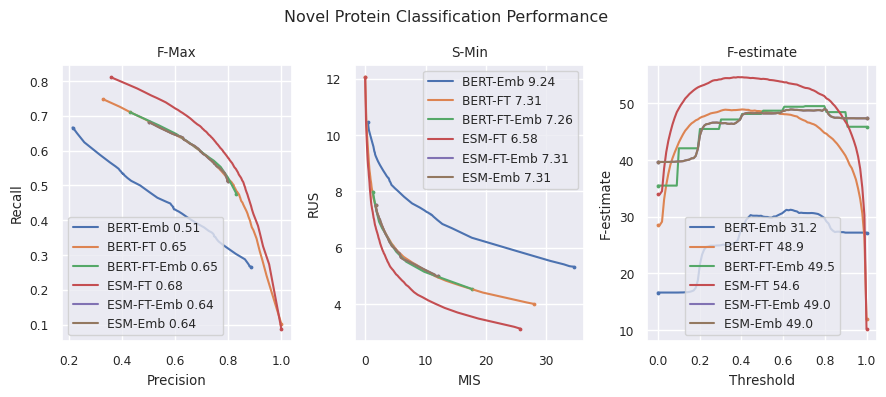

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()

def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("Novel Protein Classification Performance")

for model_name, stats in novel_stats.items():
    if(model_name in ['BLAST', 'Conv128', 'Conv128-Emb', 'Conv2048', 'Conv2048-Emb']):
        continue
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Recall")

    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}")
    axes[1].set_xlabel("MIS")
    axes[1].set_ylabel("RUS")

    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}")
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("F-estimate")
    
axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()

In [14]:
hc_mat = np.zeros(test_labels.shape[0])

for i, test_id in enumerate(test_ids):
    hc_mat[i] = hit_counts[test_id]
w_mat = hc_mat > 0
# hc_mat = np.zeros_like(hc_mat)+1
dw_mat = 1/(1+w_mat)

ml_pred = model_probs["BERT-FT-Emb"].toarray()
blast_pred = model_probs["BLAST"].toarray()
weighted_preds = (ml_pred + w_mat.reshape((-1, 1))*blast_pred)*dw_mat.reshape((-1, 1))
model_probs["Weighted"] = csr_matrix(weighted_preds)

In [15]:
model_stats = {"BLAST": threshold_stats(test_labels, model_probs["BLAST"], test_ia),
                  "BERT-FT-Emb": threshold_stats(test_labels, model_probs["BERT-FT-Emb"], test_ia),
                  "Weighted": threshold_stats(test_labels, model_probs["Weighted"], test_ia),
                  }

(3,)


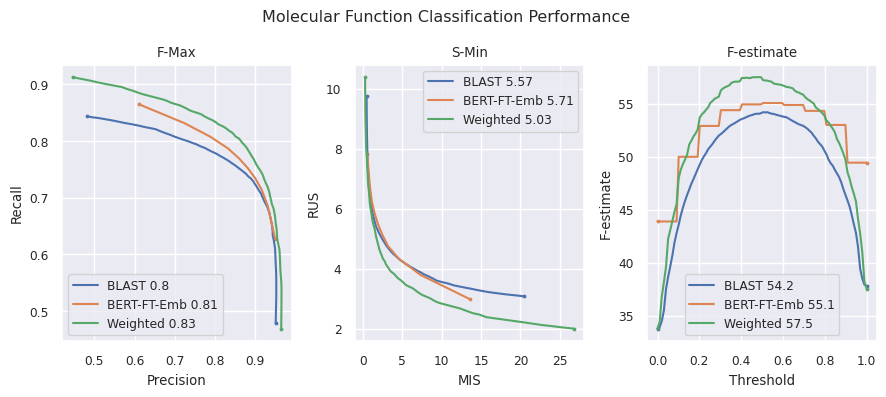

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()

def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("Molecular Function Classification Performance")

for model_name, stats in model_stats.items():
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}")
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Recall")

    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}")
    axes[1].set_xlabel("MIS")
    axes[1].set_ylabel("RUS")

    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}")
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("F-estimate")

# axes[0].set_xlim([0.25, 1])
# axes[0].set_ylim([0, 0.9])
# axes[1].set_xlim([-3, 50])
# axes[1].set_ylim([2, 20])
# axes[2].set_xlim([0, 1.1])
# axes[2].set_ylim([0, 60])

axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()

In [30]:
# plt.hist(hc_mat.flatten(), bins=np.arange(30))
# plt.show()
cutoff_stats = {}
for cutoff in np.arange(30):
    tid_mask = hc_mat <= cutoff
    novel_stats = {}
    for model, probs in model_probs.items():
        novel_labels = test_labels[tid_mask]
        novel_probs = probs[tid_mask]
        novel_stats[model] = threshold_stats(novel_labels, novel_probs, test_ia)
    cutoff_stats[cutoff] = novel_stats
    

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrew/go_bench/src/go_bench/metrics.py:66: RuntimeWarning: invalid value encountered in double_scalars
  rms.append(r*r * preds.shape[0] * preds.shape[1] / preds.sum())


In [35]:
from collections import defaultdict
cutoff_curves = {model_name: defaultdict(list) for model_name in novel_stats.keys()}
for cutoff in range(len(cutoff_stats.keys())):
    for model_name in cutoff_stats[cutoff].keys():
        precs, recs, f_scores, rms, mis, rus, s_vals = stats
        d = cutoff_curves[model_name]
        d['F-max'].append(max(f_scores))
        d['S-min'].append(min(s_vals))
        d['F-est'].append(max(rms))

In [36]:
print(cutoff_curves['BLAST'])

defaultdict(<class 'list'>, {'F-max': [0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113, 0.8312094612240113], 'S-min': [5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.03069811328694, 5.030698

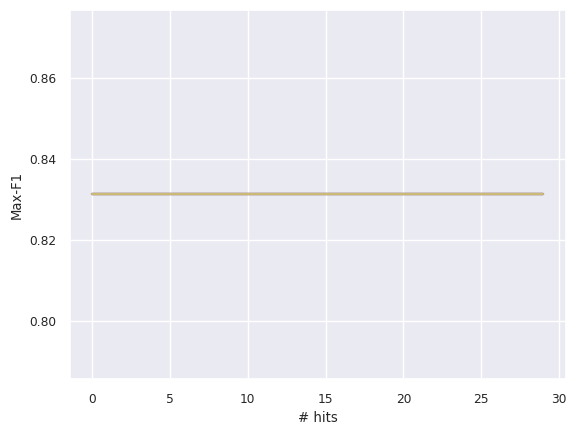

In [34]:
cutoff_curves.keys()
for model_name, ccd in cutoff_curves.items():
    plt.plot(ccd['F-max'])
plt.xlabel('# hits')
plt.ylabel('Max-F1')
plt.show()